In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
# import data
formatted_date = datetime.now().strftime("%Y.%m.%d")
root = '/Users/grantongo/Desktop/nature methods/figures/data/olink-nelisa-pbmc'
rootfig ='/Users/grantongo/Desktop/nature methods/figures/figure si.9 (olink-nelisa)'

# target mapping
target_map = pd.read_csv(f"{root}/target_mapping.csv")
nelid_to_uniprot = dict(zip(target_map['nelSensorShorthand'],target_map['UniProt']))
nelid_to_target = dict(zip(target_map['nelSensorShorthand'],target_map['Target']))

# import head to head data
df = pd.read_csv('/Users/grantongo/Desktop/nature methods/figures/figure si.9 (olink-nelisa)/data_df_olink_nelisa.csv')

olink_signal = 'NPX'
nelisa_signal = 'nELISA SNR'

In [5]:
# calculate Spearman correlation 

df_spearman = pd.DataFrame()
for nel in nelid_to_uniprot.keys(): 
    
    df_target = df[(df['nELISA ID']==nel) & 
                   (df['nELISA SNR']>3) & 
                   (df['NPX']>df['NCLOD'])].dropna(subset=[nelisa_signal,olink_signal])
    
    if len(df_target)>0:
        coef, p = spearmanr(df_target[nelisa_signal],df_target[olink_signal])
        df_spearman = pd.concat((df_spearman,
                                 pd.DataFrame({'nELISA ID':[nel],
                                               'uniprot':[nelid_to_uniprot[nel]],
                                               'coef':[coef],
                                               'pval':[p],
                                               'n_datapoints':[len(df_target)]})), axis=0)

        
df_spearman_significant = df_spearman[df_spearman.pval<0.05]

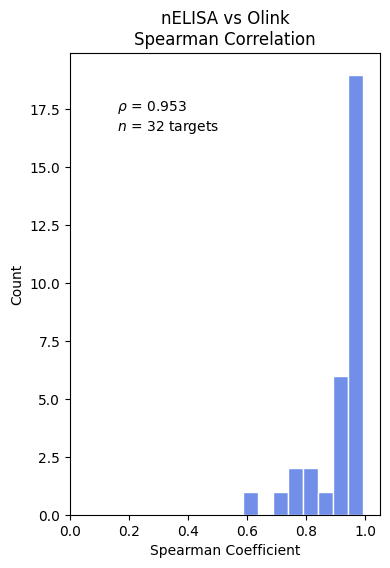

In [6]:
fig, ax = plt.subplots(1,1,figsize=(4,6),gridspec_kw={'wspace':0.4, 'hspace':0.4})
ax = sbn.histplot(abs(df_spearman_significant.coef),
                  color='royalblue',
                  edgecolor='White',
                  bins=8, kde=False, ax = ax)
ax.set_xlabel(f'Spearman Coefficient')
ax.set_ylabel('Count')
ax.set_title(f'nELISA vs Olink\nSpearman Correlation')
ax.set_xlim([0,1.05])
ax.text(0.15, 0.9, 
           f'$\\rho$ = {str(np.round(np.nanmedian(df_spearman_significant.coef),decimals=3))}\n$n$ = {len(df_spearman_significant)} targets',
           ha='left', 
           va='top', 
           transform=ax.transAxes)

fig.savefig(f'{rootfig}/spearman_correlation_histogram_SNR>3_NPX>NCLOD_{olink_signal}_{formatted_date}.svg',bbox_inches='tight', dpi=300)

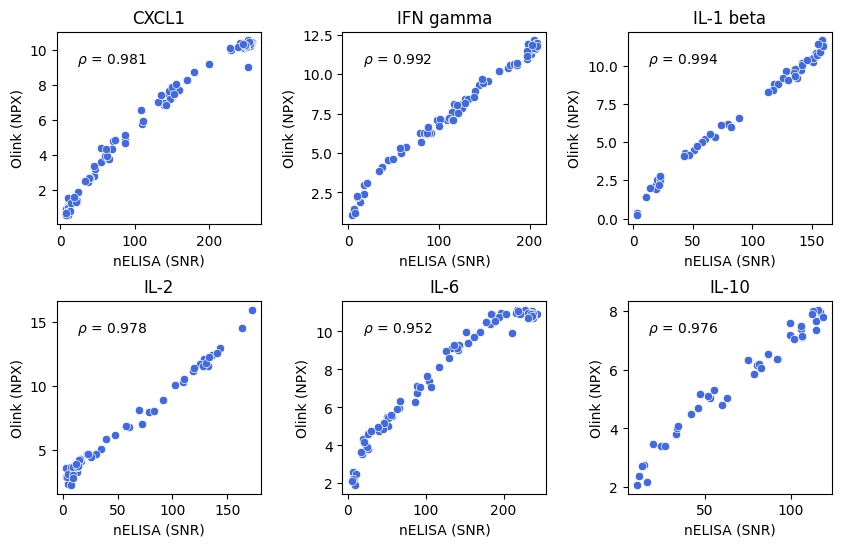

In [7]:
subplot_correlations = ['31.1 - CXCL1 - nEL xDR', 
                        '60.3 - IFN gamma - nEL xDR - 1166',
                        '85.2 - IL-1 beta - nEL xDR - 1154',
                        '65.1 - IL-2 - nEL xDR', 
                        '70.2 - IL-6 - nEL xDR - 1102',
                        '74.3 - IL-10 - nEL xDR',                       
                        ]


fig, ax = plt.subplots(2,3,figsize=(10,6),gridspec_kw={'wspace':0.4, 'hspace':0.4})

ax = ax.ravel()

for i, nel in zip(range(0,len(subplot_correlations)),subplot_correlations):
    df_target = df[(df['nELISA ID']==nel) & 
                   (df['nELISA SNR']>3) & 
                   (df['NPX']>df['NCLOD'])].dropna(subset=[nelisa_signal, olink_signal])

    if len(df_target)>0:
        ax[i] = sbn.scatterplot(data=df_target, 
                                x=nelisa_signal, 
                                y=olink_signal, 
                                color='royalblue',
                                ax=ax[i],
                                legend=False
                               )
        ax[i].set_xlabel(f'nELISA (SNR)')
        ax[i].set_ylabel(f'Olink (NPX)')
        ax[i].set_title(f"{nelid_to_target[nel]}")
        ax[i].text(0.1, 0.9, 
           f'$\\rho$ = {str(np.round(df_spearman.loc[(df_spearman["nELISA ID"]==nel),"coef"][0],decimals=3))}',
           ha='left', 
           va='top', 
           transform=ax[i].transAxes)

fig.savefig(f'{rootfig}/cross_correlation_subset_{olink_signal}_{nelisa_signal}_{formatted_date}.svg',dpi=200)